In [256]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [55]:
top_k = None 
n_i = 52
n_v = 56
dataset_path = 'hpatches_sequences/hpatches-sequences-release'

In [257]:
# Defining some basic functions

def load_data(file_name):
    """
    Load data from a .npy file.

    Args:
        file_name: The name of the file to load.
    Returns:
        img_type: array shape (n_images, 1) containing the type of each image
        num_keypoints: array shape (n_images, 1) containing the number of keypoints detected in each image
        num_matches: array shape (n_images, 1) containing the number of matches detected in each image pair
    """

    data = np.load(file_name, allow_pickle=True)
    img_type = data[2][0]
    num_keypoints = data[2][1]
    num_matches= data[2][2]
    return img_type, num_keypoints, num_matches

def generate_read_function(method, extension='ppm'):
    """
    Generate a function to read the keypoints and descriptors of a given method.

    Args:
        method: The name of the method to read.
        extension: The extension of the images.
    Returns:
        read_function: A function that reads the keypoints and descriptors of a given image.
    """
    
    def read_function(seq_name, im_idx):
        aux = np.load(os.path.join(dataset_path, seq_name, '%d.%s.%s' % (im_idx, extension, method)))
        return aux['keypoints'], aux['descriptors']
    return read_function

Number of features and matches

In [225]:
# the number of detected keypoints per image on the one axis and the number of detected matches on the other axis and color by algorithm
methods = [ 'sift', 'siftSOS', 'keynet', 'disk']
res_files = sorted([file for file in os.listdir('res/') if file.endswith('.npy')])

df = pd.DataFrame(columns=['type', 'keypoints', 'matches', 'algorithm', 'image'])

summary_df = pd.DataFrame(columns=['algorithm', 'mean_keypoints', 'mean_matches', 'mean_ratio'])


for file in res_files:
    algorithm = file.split('.')[0]
    img_type, num_keypoints, num_matches = load_data(os.path.join('res/', file))

    summary_row = pd.DataFrame({
        'algorithm': [algorithm],
        'mean_keypoints': [np.mean(num_keypoints)],
        'mean_matches': [np.mean(num_matches)],
        'mean_ratio': [np.mean(num_matches) / np.mean(num_keypoints)]
    })
    summary_df = pd.concat([summary_df, summary_row], ignore_index=True)

    type_img = [img_type[x:x+5] for x in range(0, len(img_type), 5)]
    keypoints_img = [num_keypoints[x:x+6] for x in range(0, len(num_keypoints), 6)]
    matches_img = [num_matches[x:x+5] for x in range(0, len(num_matches), 5)]

    for i in range(len(keypoints_img)):
        for j in range(1, len(keypoints_img[i])):
            row = pd.DataFrame({
                    'type': [type_img[i][j-1]],
                    'keypoints': [np.mean([keypoints_img[i][0], keypoints_img[i][j]])],
                    'matches': [matches_img[i][j-1]],
                    'algorithm': [algorithm],
                    'image': [j]
                    })
            df = pd.concat([df, row], ignore_index=True)

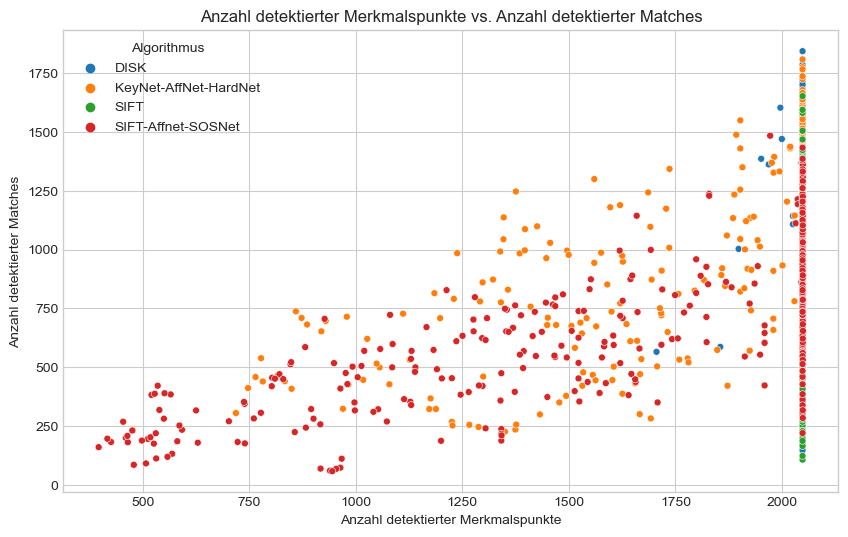

In [226]:
name_mapping = {
    'sift': 'SIFT',
    'siftSOS': 'SIFT-Affnet-SOSNet',
    'keynet': 'KeyNet-AffNet-HardNet',
    'disk': 'DISK'
}

df['algorithm'] = df['algorithm'].map(name_mapping)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='keypoints', y='matches', hue='algorithm', data=df, s=25)

plt.title('Anzahl detektierter Merkmalspunkte vs. Anzahl detektierter Matches')
plt.xlabel('Anzahl detektierter Merkmalspunkte')
plt.ylabel('Anzahl detektierter Matches')
plt.legend(title='Algorithmus')

In [255]:
methods = [ 'sift', 'siftSOS', 'keynet', 'disk']
res_files = sorted([file for file in os.listdir('res/') if file.endswith('.npy')])

#df = pd.DataFrame(columns=['type', 'keypoints', 'matches', 'algorithm', 'image'])

#summary_df = pd.DataFrame(columns=['algorithm', 'mean_keypoints', 'mean_matches', 'mean_ratio'])


for file in res_files:
    algorithm = file.split('.')[0]
    img_type, num_keypoints, num_matches = load_data(os.path.join('res/', file))
    

M-Score

In [258]:
def compute_m_score(matches, keypoints1, keypoints2):
    """"
    Compute the m-score of a given image pair.

    Args:
        matches: The number of matches detected.
        keypoints1: The number of keypoints detected in the first image.
        keypoints2: The number of keypoints detected in the second image.
    Returns:
        m_score: The m-score of the image pair.
    """
    
    m_score = matches / min(keypoints1, keypoints2) 
    return m_score

In [189]:
methods = ['sift', 'siftSOS', 'keynet', 'disk']

res_files = sorted([file for file in os.listdir('res/') if file.endswith('.npy')])
m_scores = {key: 0 for key in methods}

for file in res_files:

    _, num_keypoints, num_matches = load_data(os.path.join('res/', file))

    keypoints_img = [num_keypoints[x:x+6] for x in range(0, len(num_keypoints), 6)]
    matches_img = [num_matches[x:x+5] for x in range(0, len(num_matches), 5)]

    score_list = []

    for i in range(len(keypoints_img)):
        image_score = []

        for j in range(1, len(keypoints_img[i])):
            m_score = compute_m_score(matches_img[i][j-1], keypoints_img[i][0], keypoints_img[i][j])
            image_score.append(m_score) 

        score_list.append(image_score)
        
    m_scores[file.split('.')[0]] = score_list   


In [190]:
import itertools

for key in m_scores.keys():
    m_scores[key] = list(itertools.chain(*m_scores[key]))

In [219]:
m_score = {key: [item for item in value] for key, value in m_scores.items()}
df_m_score = pd.DataFrame(m_score)

original_columns = ['sift', 'siftSOS', 'keynet', 'disk']
new_columns = ['SIFT', 'SIFT-Affnet-SOSNet', 'KeyNet-AffNet-HardNet', 'DISK']

column_mapping = dict(zip(original_columns, new_columns))

df_m_score.rename(columns=column_mapping, inplace=True)

df_m_score_i = df_m_score.iloc[0:52*5]
df_m_score_v = df_m_score.iloc[52*5:]

In [209]:
indices_small = [i for j in range(0, len(df_m_score), 5) for i in (j, j+1)]
df_m_score_small_change = df_m_score.iloc[indices_small]

indices_huge = [i for j in range(3, len(df_m_score), 5) for i in (j, j+1)]
df_m_score_huge_change = df_m_score.iloc[indices_huge]

small_means = df_m_score_small_change.mean(axis=0)
huge_means = df_m_score_huge_change.mean(axis=0)

df_m_score_means = pd.concat([small_means, huge_means], axis=1)
df_m_score_means.columns = ['small_change', 'huge_change']


,small_change,huge_change
SIFT,0.431552,0.310239
SIFT-Affnet-SOSNet,0.508680,0.434678
KeyNet-AffNet-HardNet,0.582221,0.453658
DISK,0.581288,0.449545


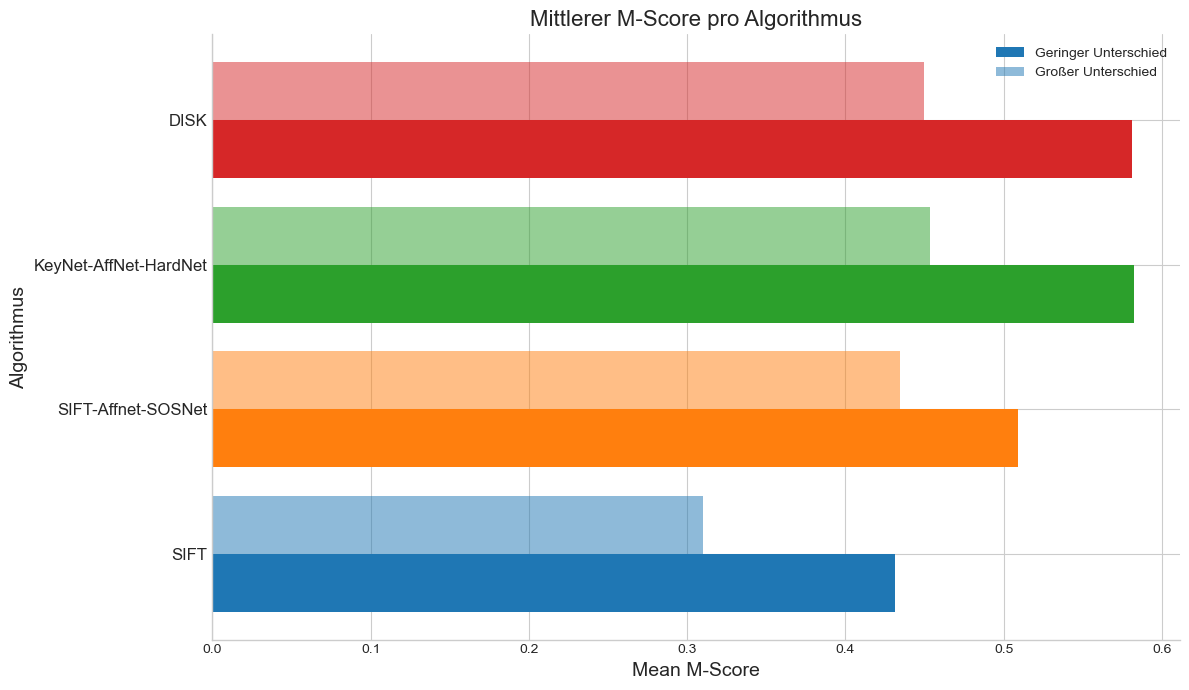

In [216]:
labels = df_m_score_means.index
bar_width = 0.4  
index = np.arange(len(labels))
colors = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728']

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

for i, color in enumerate(colors):
    ax.barh(index[i] - bar_width/2, df_m_score_means.loc[labels[i], 'small_change'], bar_width, label='Geringer Unterschied' if i==0 else "", color=color, align='center', capsize=5)

for i, color in enumerate(colors):
    ax.barh(index[i] + bar_width/2, df_m_score_means.loc[labels[i], 'huge_change'], bar_width, label='Großer Unterschied' if i==0 else "", color=color, alpha=0.5, align='center', capsize=5)

ax.set_ylabel('Algorithmus', fontname='Arial', fontsize=14)
ax.set_xlabel('Mean M-Score', fontname='Arial', fontsize=14)
ax.set_title('Mittlerer M-Score pro Algorithmus', fontname='Arial', fontsize=16)
ax.set_yticks(index)
ax.set_yticklabels(labels, fontname='Arial', fontsize=12)
ax.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

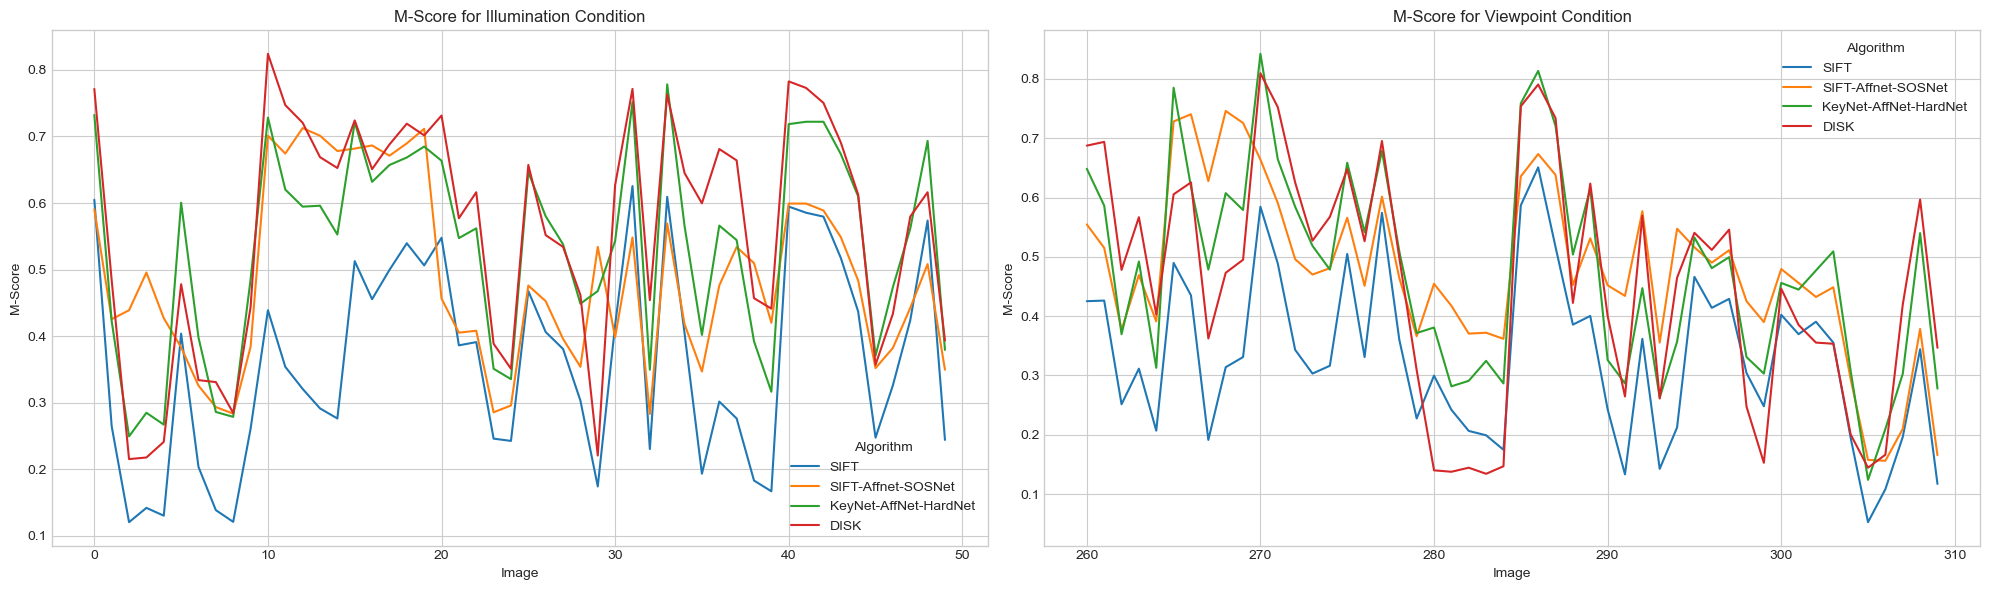

In [198]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

# First Plot for Illumination Condition
sns.lineplot(data=df_m_score_i.iloc[:50], dashes=False, ax=ax[0])
ax[0].set_title('M-Score for Illumination Condition')
ax[0].set_xlabel('Image')
ax[0].set_ylabel('M-Score')
ax[0].legend(title='Algorithm')

# Second Plot for Viewpoint Condition
sns.lineplot(data=df_m_score_v.iloc[:50], dashes=False, ax=ax[1])
ax[1].set_title('M-Score for Viewpoint Condition')
ax[1].set_xlabel('Image')
ax[1].set_ylabel('M-Score')
ax[1].legend(title='Algorithm')

plt.tight_layout()
plt.show()

Runtime

/var/folders/sd/ks8n1_fs1095g49dhzxt2zvr0000gn/T/ipykernel_96494/582660998.py:10: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='Algorithm', y='Runtime', data=runtime_melted, palette=color_palette, jitter=True, size=5)


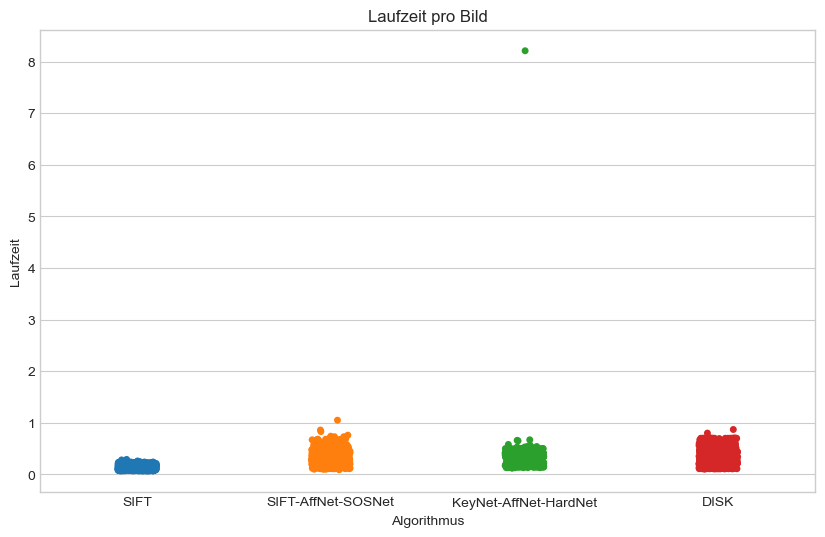

In [224]:
runtime = pd.read_csv('res/runtimes.csv')

runtime_melted = runtime.melt(var_name='Algorithm', value_name='Runtime')

colors = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728']
color_palette = dict(zip(runtime_melted['Algorithm'].unique(), colors))

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.stripplot(x='Algorithm', y='Runtime', data=runtime_melted, palette=color_palette, jitter=True, size=5)

plt.title('Laufzeit pro Bild')
plt.ylabel('Laufzeit')
plt.xlabel('Algorithmus')

plt.show()


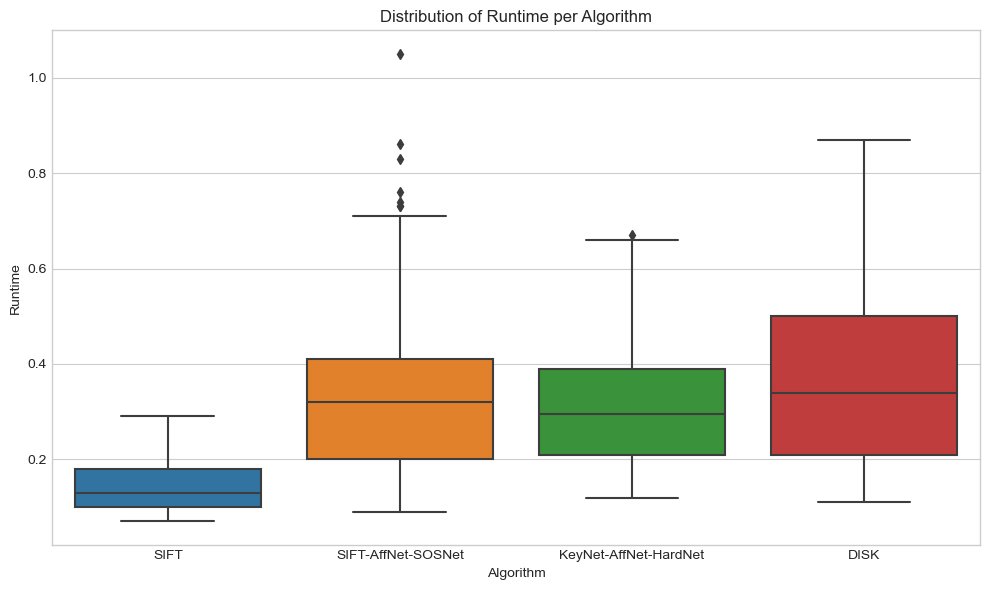

In [182]:
colors = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728']

runtime = pd.read_csv('res/runtimes.csv')
runtime_melted = runtime.melt(var_name='Algorithm', value_name='Runtime')

algos = ['SIFT', 'SIFT-AffNet-SOSNet', 'KeyNet-AffNet-HardNet', 'DISK']
color_palette = dict(zip(algos, colors))

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Algorithm', y='Runtime', data=runtime_melted, palette=color_palette)
plt.title('Distribution of Runtime per Algorithm')
plt.tight_layout()
plt.show()

Repeatability

In [259]:
def check_correctness(xi, keypoints, epsilon):
    """"
    Check if a given keypoint is correct by checking if it is within a given threshold for any of the keypoints in the other image.

    Args:
        xi: The keypoint coordinate to check.
        keypoints: The keypoints of the image.
        epsilon: The threshold to check if a keypoint is correct.
    Returns:
        True if the keypoint is correct, False otherwise.
    """

    return np.min(np.linalg.norm(keypoints - xi, axis=1)) <= epsilon

def determine_repeatability(read_feats, method):
    """"
    Determine the repeatability of a given method.

    Args:
        read_feats: A function that reads the keypoints and descriptors of a given image.
        method: The name of the method to read.
    Returns:
        repeatability_df: A dataframe containing the repeatability of the method for each image pair.
    """
    
    seq_names = sorted(os.listdir(dataset_path))

    repeatability_df = pd.DataFrame(columns=['type', 'image', 'repeatability', 'algorithm'])

    for _, seq_name in enumerate(seq_names):
        image_type = seq_name.split('_')[0]
        keypoints_a, _ = read_feats(seq_name, 1)

        for im_idx in range(2, 7):
            keypoints_b, _ = read_feats(seq_name, im_idx)
            
            homography = np.loadtxt(os.path.join(dataset_path, seq_name, "H_1_" + str(im_idx)))

            pos_a = keypoints_a[:, : 2]

            pos_a_h = np.concatenate([pos_a, np.ones([pos_a.shape[0], 1])], axis=1)
            pos_b_proj_h = np.transpose(np.dot(homography, np.transpose(pos_a_h)))
            pos_b_proj = pos_b_proj_h[:, : 2] / pos_b_proj_h[:, 2 :]

            pos_b = keypoints_b[:, : 2]

            corr_ref = [check_correctness(pt_a, pos_b, 3) for pt_a in pos_b_proj]
            corr_sensed = [check_correctness(pt_b, pos_b_proj, 3) for pt_b in pos_b]

            repeatability = (sum(corr_ref) + sum(corr_sensed)) / (len(pos_b_proj) + len(pos_b))

            repeatability_row = pd.DataFrame({
                'type': [image_type],
                'image': [im_idx],
                'repeatability': [repeatability],
                'algorithm': [method]
            })
            repeatability_df = pd.concat([repeatability_df, repeatability_row], ignore_index=True)
    
    return repeatability_df
    

In [183]:
res_cache = []
methods = [ 'sift', 'siftSOS', 'keynet', 'disk']

for method in methods:
    print(method)
    read_function = generate_read_function(method)
    result_df = determine_repeatability(read_function, method)
    res_cache.append(result_df)

repeatability = pd.concat(res_cache, ignore_index=True)
repeatability.to_csv('./res/repeatability_scores.csv', index=False)

sift
siftSOS
keynet
disk


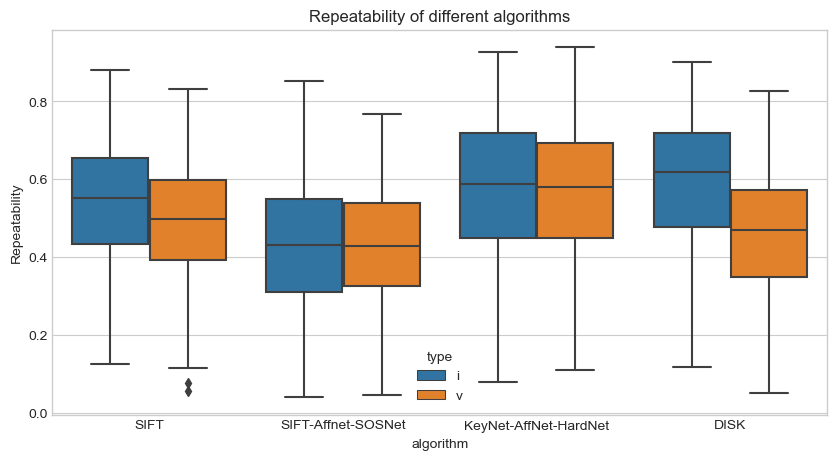

In [227]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='algorithm', y='repeatability', hue='type', data=repeatability)
plt.ylabel('Repeatability')
plt.title('Repeatability of different algorithms')
plt.show()

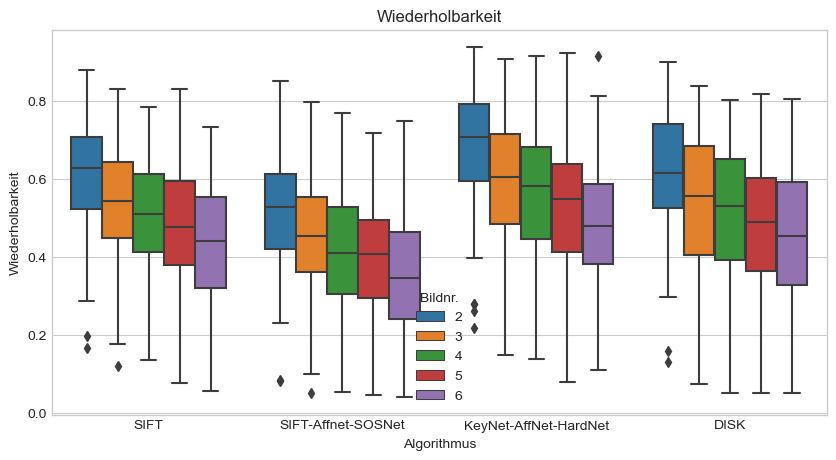

In [254]:
# Plot the repeatability distributions as a boxplot of the different algorithms but once only taking into account the images with image col value 2 or 3 and once only taking into account the images with image col value 5 or 6
names = ['SIFT', 'SIFT-Affnet-SOSNet', 'KeyNet-AffNet-HardNet', 'DISK']
algos = ['sift', 'siftSOS', 'keynet', 'disk']

# Replace the 'algorithm' names in the repeatability dataframe
#repeatability['Algorithmus'] = repeatability['algorithm'].replace(algos, names)
#repeatability.rename(columns={'algorithm': 'Algorithmus'}, inplace=True)
repeatability.rename(columns={'image': 'Bildnr.'}, inplace=True)

plt.figure(figsize=(10, 5))
sns.boxplot(x='Algorithmus', y='repeatability', hue='Bildnr.', data=repeatability)
plt.ylabel('Wiederholbarkeit')
plt.title('Wiederholbarkeit')
plt.show()

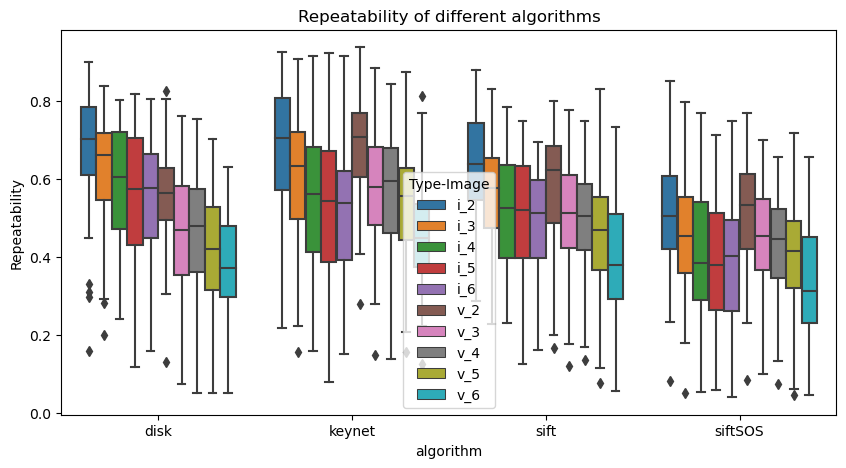

In [93]:
repeatability['type_image'] = repeatability['type'].astype(str) + "_" + repeatability['image'].astype(str)

plt.figure(figsize=(10, 5))
sns.boxplot(x='algorithm', y='repeatability', hue='type_image', data=repeatability)
plt.ylabel('Repeatability')
plt.title('Repeatability of different algorithms')
plt.legend(title='Type-Image')
plt.show()

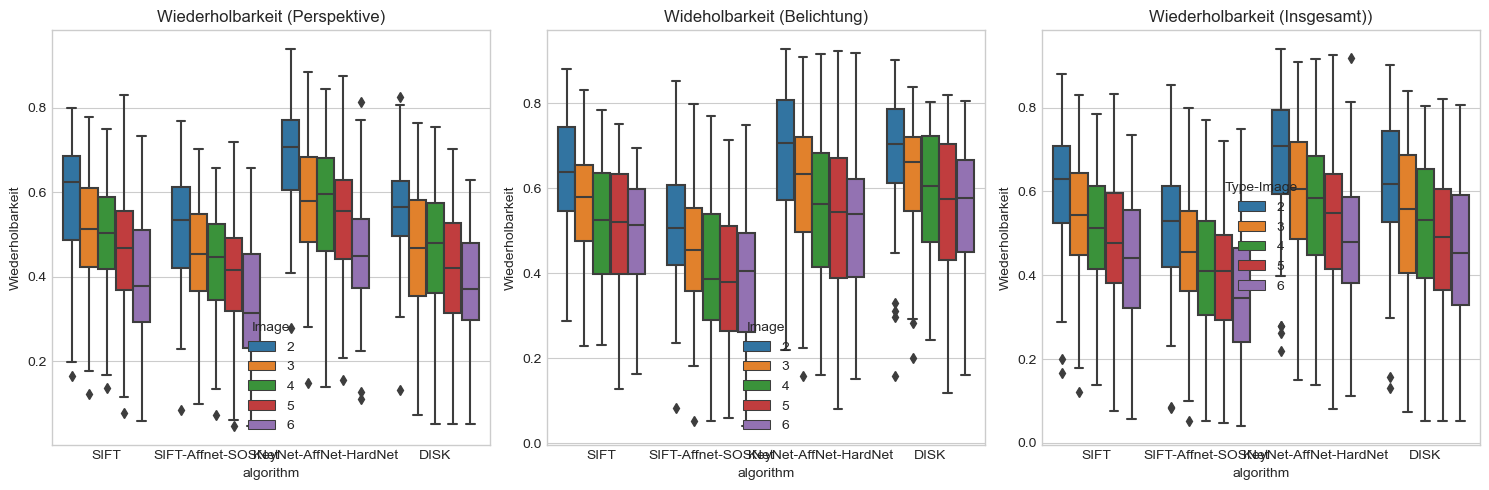

In [188]:
# Create a larger figure with 1 row and 3 columns for three plots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Leftmost plot showing distribution only for type "v"
sns.boxplot(x='algorithm', y='repeatability', hue='image', data=repeatability[repeatability['type'] == 'v'], ax=ax[0])
ax[0].set_ylabel('Wiederholbarkeit')
ax[0].set_title('Wiederholbarkeit (Perspektive)')
ax[0].legend(title='Image')

# Middle plot showing distribution only for type "I"
sns.boxplot(x='algorithm', y='repeatability', hue='image', data=repeatability[repeatability['type'] == 'i'], ax=ax[1])
ax[1].set_ylabel('Wiederholbarkeit')
ax[1].set_title('Wideholbarkeit (Belichtung)')
ax[1].legend(title='Image')

# Rightmost plot showing distribution for all types
sns.boxplot(x='algorithm', y='repeatability', hue='image', data=repeatability, ax=ax[2])
ax[2].set_ylabel('Wiederholbarkeit')
ax[2].set_title('Wiederholbarkeit (Insgesamt))')
ax[2].legend(title='Type-Image')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


Visualize image sequence by index

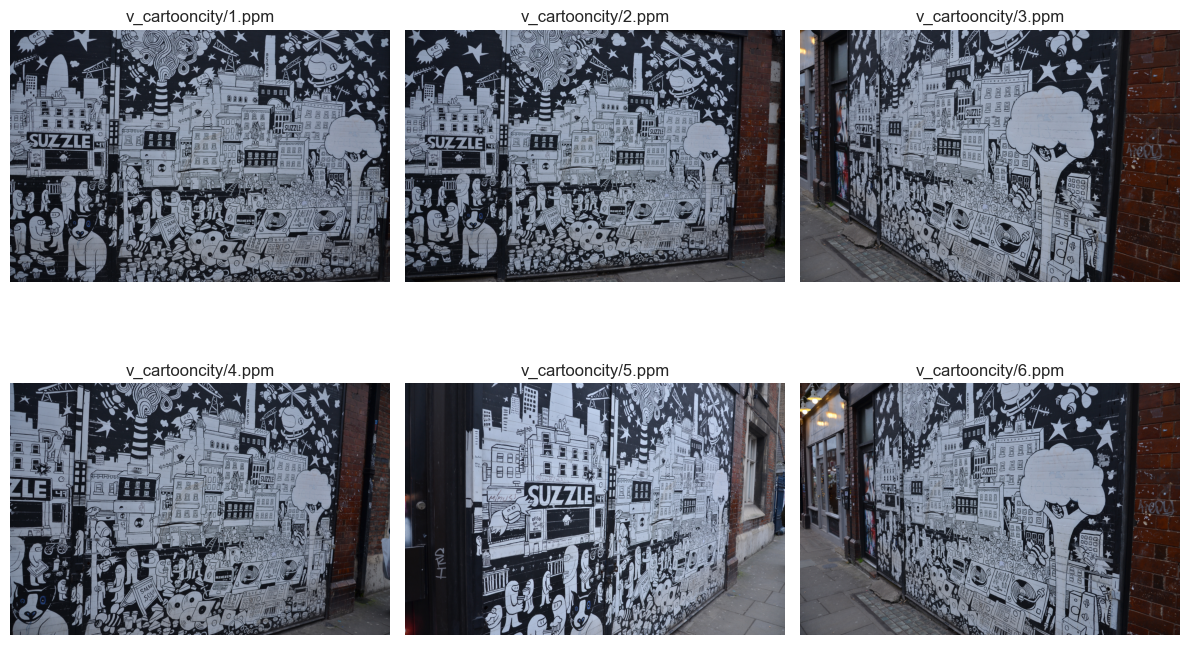

In [175]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os

folders = os.listdir('hpatches_sequences/hpatches-sequences-release')
folders = sorted(folders)  # Sorting ensures consistency in the order of folders

def get_ppm_files(folder_path):
    """
    Get all .ppm files from the given folder.
    """
    files = os.listdir(folder_path)
    ppm_files = [file for file in files if file.endswith('.ppm')]
    return sorted(ppm_files)  # Sorting ensures consistency in the order of files

def plot_ppm_files(index):
    """
    Plot all .ppm files for the folder at the given index.
    """
    folder_path = os.path.join('hpatches_sequences/hpatches-sequences-release', folders[index])
    ppm_files = get_ppm_files(folder_path)
    
    plt.figure(figsize=(12, 8))
    
    for i, ppm_file in enumerate(ppm_files, 1):
        img_path = os.path.join(folder_path, ppm_file)
        img = mpimg.imread(img_path)
        plt.subplot(2, 3, i)  # Assuming there are 6 .ppm files
        plt.imshow(img)
        plt.title(folders[index] + "/" + ppm_file)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Using the function:
index = 67 # Replace with your desired index
plot_ppm_files(index)
